In [63]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

In [64]:
import autoencoder.aecExtraFeatures as Z_calculations

def addZToPrediction(model, data_point):
    encoded = model.encoder(data_point)
    reconstruction = model.decoder(encoded)

    Z_features = [Z_calculations.getZVector(data_point, reconstruction, encoded)]

    Z_features_tensor = tf.convert_to_tensor(Z_features, dtype=tf.float32)
    data_point = tf.convert_to_tensor(data_point, dtype=tf.float32)

    data_point = tf.concat([data_point, Z_features_tensor], 1)

    return data_point

In [65]:
def isAnomaly(data_point, model_1, model_2, threshold):

    # need autoencoder to return boolean isAnomaly
    isAnomaly = tf.math.less(tf.keras.losses.mae(model_1(data_point), data_point), threshold)

    # if the autoencoder doesn't find anything out of the ordinary, return False
    if not isAnomaly:
        return False

    data_point = addZToPrediction(model_1, data_point)

    # if the autoencoder sees something weird, run it through the isolation forest to make sure
    return model_2.predict(data_point)

In [66]:
from turtleIsolationForests.preprocessFeatures import preprocess_features

train_dataframe = pd.read_csv("eda_simple_classification/network_data_mod_train.csv", index_col=0)
test_dataframe = pd.read_csv("eda_simple_classification/network_data_mod_test.csv", index_col=0)

train_data, test_data, train_labels, test_labels = preprocess_features(train_dataframe, test_dataframe)

In [67]:
#train_data, test_data, train_labels, test_labels = train_data[:1000], test_data[:1000], train_labels[:1000], test_labels[:1000]

In [68]:
np_train_labels = train_labels.to_numpy()
np_test_labels = test_labels.to_numpy()

In [69]:
np_train_data = train_data.to_numpy()
np_test_data = test_data.to_numpy()

In [70]:
np_train_data = tf.cast(np_train_data, tf.float32)
np_test_data = tf.cast(np_test_data, tf.float32)

In [71]:
np_train_labels = np_train_labels.astype(bool)
np_test_labels = np_test_labels.astype(bool)

normal_train_data = np_train_data[np_train_labels]
normal_test_data = np_test_data[np_test_labels]

anomalous_train_data = np_train_data[~np_train_labels]
anomalous_test_data = np_test_data[~np_test_labels]

In [72]:
from autoencoder.autoencoder import AnomalyDetector
autoencoder = AnomalyDetector()

In [73]:
autoencoder.compile(optimizer='adam', loss='mae')

In [74]:
history = autoencoder.fit(normal_train_data, normal_train_data,
          epochs=100,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/100
Tensor("anomaly_detector_1/sequential_2/dense_8/Relu:0", shape=(None, 8), dtype=float32)
Tensor("anomaly_detector_1/sequential_3/dense_11/Sigmoid:0", shape=(None, 46), dtype=float32)
Tensor("anomaly_detector_1/sequential_2/dense_8/Relu:0", shape=(None, 8), dtype=float32)
Tensor("anomaly_detector_1/sequential_3/dense_11/Sigmoid:0", shape=(None, 46), dtype=float32)
2086/2105 [============================>.] - ETA: 0s - loss: 0.2904Tensor("anomaly_detector_1/sequential_2/dense_8/Relu:0", shape=(None, 8), dtype=float32)
Tensor("anomaly_detector_1/sequential_3/dense_11/Sigmoid:0", shape=(None, 46), dtype=float32)
2105/2105 [==============================] - 10s 4ms/step - loss: 0.2902 - val_loss: 0.4173
Epoch 2/100
2105/2105 [==============================] - 7s 3ms/step - loss: 0.2733 - val_loss: 0.4137
Epoch 3/100
2105/2105 [==============================] - 5s 2ms/step - loss: 0.2720 - val_loss: 0.4114
Epoch 4/100
2105/2105 [==============================] - 5s 3ms/step - los

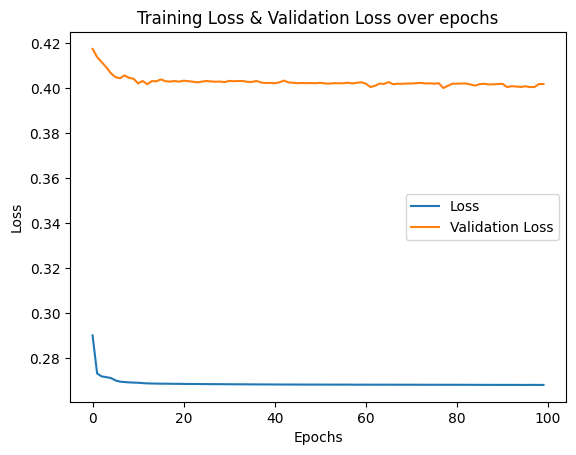

In [75]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Training Loss & Validation Loss over epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
#plt.ylim([0,.0008])
plt.legend(["Loss", "Validation Loss"])
plt.show()

In [76]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Tensor("anomaly_detector_1/sequential_2/dense_8/Relu:0", shape=(None, 8), dtype=float32)
Tensor("anomaly_detector_1/sequential_3/dense_11/Sigmoid:0", shape=(None, 46), dtype=float32)
2105/2105 [==============================] - 3s 2ms/step
Threshold:  0.44103524


In [77]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(data, reconstructions) # 0 = anomaly (same as data)
  return tf.math.less(loss, threshold)

def getLoss(model, data):
    reconstructions = model(data)
    loss = tf.keras.losses.mae(data, reconstructions) # 0 = anomaly (same as data)
    return loss

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [78]:
%%timeit
%%capture

predict(autoencoder, np_test_data, threshold)

32.7 ms ± 3.64 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [79]:
%%capture

test_predictions = predict(autoencoder, np_test_data, threshold)

### Stats for whole dataset

In [80]:
print_stats(test_predictions, test_labels)

Accuracy = 0.7567423704755145
Precision = 0.6441186498465735
Recall = 0.972711358253527


In [81]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(test_labels, test_predictions))

[[7614 5219]
 [ 265 9446]]


### Stats for all predicted anomalous data

In [83]:
from pandas import DataFrame
from turtleIsolationForests.printResults import print_results
from turtleIsolationForests.printResults import get_auroc_value

test_predictions_np = test_predictions.numpy()

autoec_predictions = DataFrame()

autoec_predictions['predicted_as_anomaly'] = test_predictions_np # 0: anomalous, 1: normal
autoec_predictions['is_anomalous'] = test_labels # 0: normal, 1: anomalous
autoec_predictions['anomaly_scores'] = getLoss(autoencoder, np_test_data)

print_results(autoec_predictions)
print("auroc: " + str(get_auroc_value(autoec_predictions)))

true anomalies: 9446
false anomalies: 5219
false normals: 265
true normals: 7614
precision: 0.6441186498465735
recall: 0.972711358253527
f1-score: 0.775024614374795


In [84]:
def addZToData(data, model):
    data_with_Z = []
    for i in range(1, len(data)+1):
        data_with_Z.append(addZToPrediction(model, data[i-1:i]))

    data_with_Z_rf = []
    for i in range(len(data_with_Z)):
        data_with_Z_rf.append(np.append(np_train_data[:][:][i].numpy().reshape(1,46).squeeze(), data_with_Z[i]))

    return pd.DataFrame(data_with_Z_rf)

In [85]:
train_data_with_Z_df = addZToData(np_train_data, autoencoder)

In [86]:
train_data_with_Z_df

,0,1,2,3,4,5,6,7,8,9,...,85,86,87,88,89,90,91,92,93,94
0,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,-0.618438,-0.053906,-0.031767,-0.019726,0.825150,...,-0.280282,0.069972,-0.289103,-0.639532,-0.624871,-0.224532,-0.376387,3.583353,2.395793,0.426715
1,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,-0.618438,-0.053906,-0.031767,-0.019726,0.825150,...,2.736852,2.367737,-0.289103,-0.639532,-0.624871,-0.387635,-0.376387,5.872164,4.207399,0.514389
2,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,1.616978,-0.053906,-0.031767,-0.019726,-1.211901,...,-0.174417,-0.480197,-0.289103,1.608759,1.618955,-0.387635,-0.376387,8.845963,4.824546,-0.307002
3,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,-0.618438,-0.053906,-0.031767,-0.019726,0.825150,...,-0.439078,-0.383108,0.066252,-0.572083,-0.602433,-0.387635,-0.345084,1.821037,2.350297,0.707768
4,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,-0.618438,-0.053906,-0.031767,-0.019726,0.825150,...,-0.439078,-0.480197,-0.289103,-0.639532,-0.624871,-0.387635,-0.376387,0.084304,1.927049,0.788666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,1.616978,-0.053906,-0.031767,-0.019726,-1.211901,...,-0.121485,-0.480197,-0.289103,1.608759,1.618955,-0.387635,-0.376387,8.959674,4.794569,-0.261567
125969,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,-0.618438,-0.053906,-0.031767,-0.019726,0.825150,...,-0.386146,-0.447834,-0.289103,-0.639532,-0.624871,-0.387635,-0.376387,0.249487,2.179151,0.680840
125970,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,-0.618438,-0.053906,-0.031767,-0.019726,0.825150,...,-0.121485,-0.480197,-0.289103,0.979238,-0.624871,-0.355014,-0.376387,0.363633,2.441809,0.598059
125971,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,1.616978,-0.053906,-0.031767,-0.019726,-1.211901,...,-0.174417,-0.480197,-0.289103,1.608759,1.618955,-0.387635,-0.376387,8.722095,4.892005,-0.297027


In [87]:
np_test_labels = np.array(np_test_labels)

In [102]:
predicted_anomalous = np_test_data[~test_predictions.numpy()]

In [ ]:
test_predictions.numpy()
### should all be ones

In [ ]:
#predicted_anomalous.to_csv("predicted_anomalous.csv")

In [89]:
train_data_with_Z_df

,0,1,2,3,4,5,6,7,8,9,...,85,86,87,88,89,90,91,92,93,94
0,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,-0.618438,-0.053906,-0.031767,-0.019726,0.825150,...,-0.280282,0.069972,-0.289103,-0.639532,-0.624871,-0.224532,-0.376387,3.583353,2.395793,0.426715
1,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,-0.618438,-0.053906,-0.031767,-0.019726,0.825150,...,2.736852,2.367737,-0.289103,-0.639532,-0.624871,-0.387635,-0.376387,5.872164,4.207399,0.514389
2,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,1.616978,-0.053906,-0.031767,-0.019726,-1.211901,...,-0.174417,-0.480197,-0.289103,1.608759,1.618955,-0.387635,-0.376387,8.845963,4.824546,-0.307002
3,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,-0.618438,-0.053906,-0.031767,-0.019726,0.825150,...,-0.439078,-0.383108,0.066252,-0.572083,-0.602433,-0.387635,-0.345084,1.821037,2.350297,0.707768
4,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,-0.618438,-0.053906,-0.031767,-0.019726,0.825150,...,-0.439078,-0.480197,-0.289103,-0.639532,-0.624871,-0.387635,-0.376387,0.084304,1.927049,0.788666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,1.616978,-0.053906,-0.031767,-0.019726,-1.211901,...,-0.121485,-0.480197,-0.289103,1.608759,1.618955,-0.387635,-0.376387,8.959674,4.794569,-0.261567
125969,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,-0.618438,-0.053906,-0.031767,-0.019726,0.825150,...,-0.386146,-0.447834,-0.289103,-0.639532,-0.624871,-0.387635,-0.376387,0.249487,2.179151,0.680840
125970,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,-0.618438,-0.053906,-0.031767,-0.019726,0.825150,...,-0.121485,-0.480197,-0.289103,0.979238,-0.624871,-0.355014,-0.376387,0.363633,2.441809,0.598059
125971,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,1.616978,-0.053906,-0.031767,-0.019726,-1.211901,...,-0.174417,-0.480197,-0.289103,1.608759,1.618955,-0.387635,-0.376387,8.722095,4.892005,-0.297027


In [90]:
predicted_anomalous_labels = np_test_labels[~test_predictions.numpy()]

In [ ]:
predicted_anomalous_labels

In [91]:
anomalous_test_data_with_Z_df = addZToData(predicted_anomalous, autoencoder)

In [92]:
contamination = sum(train_labels == 0) / len(train_labels)

In [93]:
# need test_predictions replaced at indices that autoencoder predicted anomalies

In [94]:
anomalous_test_data_with_Z_df

,0,1,2,3,4,5,6,7,8,9,...,85,86,87,88,89,90,91,92,93,94
0,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,-0.618438,-0.053906,-0.031767,-0.019726,0.825150,...,-0.227350,1.493939,-0.111426,-0.639532,-0.624871,-0.387635,-0.376387,6.180758,2.220589,0.643300
1,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,-0.618438,-0.053906,-0.031767,-0.019726,0.825150,...,-0.439078,2.756092,2.198385,-0.639532,-0.624871,-0.387635,-0.376387,11.991243,5.293556,0.476488
2,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,1.616978,-0.053906,-0.031767,-0.019726,-1.211901,...,-0.439078,-0.447834,-0.022587,-0.617049,-0.624871,-0.387635,-0.376387,1.656502,2.038718,0.756733
3,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,-0.618438,-0.053906,-0.031767,-0.019726,0.825150,...,3.372038,-0.480197,-0.289103,-0.639532,-0.624871,1.961037,-0.251175,0.763901,5.691018,0.304496
4,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,-0.618438,-0.053906,-0.031767,-0.019726,0.825150,...,-0.439078,-0.447834,-0.022587,-0.639532,-0.624871,-0.387635,-0.376387,1.624299,1.946848,0.771669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14660,-0.019113,3.196020,-0.11205,-0.028606,-0.139982,-0.618438,-0.053906,-0.031767,-0.019726,-1.211901,...,-0.439078,2.756092,-0.289103,-0.639532,-0.624871,-0.387635,-0.376387,4.593998,2.677897,0.784177
14661,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,1.616978,-0.053906,-0.031767,-0.019726,-1.211901,...,-0.121485,-0.447834,-0.200265,-0.617049,-0.624871,-0.387635,-0.376387,2.240314,2.150332,0.629270
14662,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,1.616978,-0.053906,-0.031767,-0.019726,-1.211901,...,-0.439078,-0.447834,-0.200265,-0.617049,-0.624871,-0.387635,-0.376387,0.696183,2.013179,0.761464
14663,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,-0.618438,-0.053906,-0.031767,-0.019726,0.825150,...,-0.439078,-0.480197,-0.289103,-0.639532,-0.624871,-0.159292,-0.157266,0.000000,2.150937,0.753814


In [95]:
def getFinalPredictions(first_predictions, second_predictions):
    autoencoder_copy = first_predictions.copy()
    if_copy = second_predictions.copy()
    indices = autoencoder_copy.index[autoencoder_copy["predicted_as_anomaly"] == True]
    if_copy.index = indices
    autoencoder_copy.loc[indices, "predicted_as_anomaly"] = if_copy["predicted_as_anomaly"]
    print_results(autoencoder_copy)
    print("auroc: " + str(get_auroc_value(second_predictions)))

In [96]:
from turtleIsolationForests.extendedIsolationForest import ExtendedIsolationForest
from turtleIsolationForests.printResults import print_results

eif = ExtendedIsolationForest(contamination = contamination, random_state = None)
eif.fit(train_data_with_Z_df, train_labels)

In [97]:
%%timeit

eif.predict(anomalous_test_data_with_Z_df)

1min 3s ± 9.17 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [98]:
eif_predictions = eif.predict(anomalous_test_data_with_Z_df)
eif_predictions['is_anomalous'] = predicted_anomalous_labels

#print_results(eif_predictions)
getFinalPredictions(autoec_predictions, eif_predictions)

true anomalies: 2069
false anomalies: 2679
false normals: 7642
true normals: 10154
precision: 0.4357624262847515
recall: 0.21305735763567088
f1-score: 0.28618853309357495


KeyError: 'anomaly_score'

In [101]:
eif_predictions = eif.predict(anomalous_test_data_with_Z_df)
eif_predictions['is_anomalous'] = predicted_anomalous_labels

#print_results(eif_predictions)
getFinalPredictions(autoec_predictions, eif_predictions)

true anomalies: 2069
false anomalies: 2679
false normals: 7642
true normals: 10154
precision: 0.4357624262847515
recall: 0.21305735763567088
f1-score: 0.28618853309357495


KeyError: 'anomaly_score'

In [ ]:
train_predictions = eif.train_scores
train_predictions['is_anomalous'] = train_labels
print_results(train_predictions)

In [ ]:
from turtleIsolationForests.sciForest import SCIsolationForest

scif = SCIsolationForest(contamination = contamination, num_hyperplanes_per_split=5, random_state = None)
scif.fit(train_data_with_Z_df, train_labels)

In [ ]:
%%timeit

scif.predict(anomalous_test_data_with_Z_df)

In [ ]:
scif_predictions = scif.predict(anomalous_test_data_with_Z_df)
scif_predictions['is_anomalous'] = predicted_anomalous_labels

#print_results(scif_predictions)
getFinalPredictions(autoec_predictions, scif_predictions)

In [ ]:
from turtleIsolationForests.isolationForest import IsolationForest

isoforest = IsolationForest(contamination = contamination, random_state = None)
isoforest.fit(train_data_with_Z_df, train_labels)

In [ ]:
%%timeit

isoforest.predict(anomalous_test_data_with_Z_df)

In [ ]:
isoforest_predictions = isoforest.predict(anomalous_test_data_with_Z_df)
isoforest_predictions['is_anomalous'] = predicted_anomalous_labels

#print_results(isoforest_predictions)
getFinalPredictions(autoec_predictions, isoforest_predictions)

In [ ]:
from turtleIsolationForests.FBIF import FBIsolationForest

fbif = FBIsolationForest(contamination = contamination, random_state = None)
fbif.fit(train_data_with_Z_df, train_labels)

In [ ]:
%%timeit

fbif.predict(anomalous_test_data_with_Z_df)

In [ ]:
fbif_predictions = fbif.predict(anomalous_test_data_with_Z_df)
fbif_predictions['is_anomalous'] = predicted_anomalous_labels

#print_results(fbif_predictions)
getFinalPredictions(autoec_predictions, fbif_predictions)